<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/First_test_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install accelerate -U --quiet
!pip install datasets --quiet
!pip install evaluate --quiet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
import torch
from typing import Dict
import torch
from datasets import load_dataset
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, Trainer, TrainingArguments, set_seed, DataCollatorWithPadding
import evaluate
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00


In [2]:
!pip install datasets --quiet

from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
login(token="")

dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

dev_df = dataset['validation'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [3]:
#Wikipedia text (1000 characters) for each item
df_train_text = pd.read_json('/content/train_with_text.json', lines=True)[['item','text']]
df_dev_text = pd.read_json('/content/dev_with_text.json', lines=True)[['item','text']]

#500 first characters
#df_train_text['text'] = df_train_text['text'].apply(lambda x: x[:500])
#df_dev_text['text'] = df_dev_text['text'].apply(lambda x: x[:500])

# Cleaning the tables

In [4]:
# Select the labels and associated labels to correct
to_correct = train_df[train_df["label"].isin(['cultural agn','cultural represent', 'cultural ex', 'cultural ag'])][['item', 'label']]

# Create the mapping for correction
mapping_correction = {
  'cultural agn' : 'cultural agnostic',
  'cultural represent' : 'cultural representative',
  'cultural ex' : 'cultural exclusive',
  'cultural ag' : 'cultural agnostic'
}

# Apply the correction
to_correct['label'] = to_correct['label'].map(mapping_correction)

# We update the transformations to the initial dataset
train_df.set_index('item', inplace=True)
to_correct.set_index('item', inplace=True)

train_df.update(to_correct)
train_df.reset_index(inplace=True)

# Select the items that have no label, or with label 'cultural', or 'cult'
to_classify = train_df[(train_df["label"].isin(["cultural", "cult"])) | (train_df["label"].isna())][['item', 'name', 'description']]

# Create the dictionnary for the mapping
categories = {
    'http://www.wikidata.org/entity/Q957033': 'cultural representative',
    'http://www.wikidata.org/entity/Q30327019': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q811361': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q12014207': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q257907': 'cultural exclusive',
    'http://www.wikidata.org/entity/Q1136336': 'cultural representative',
    'http://www.wikidata.org/entity/Q67111': 'cultural representative',
    'http://www.wikidata.org/entity/Q1089672': 'cultural representative',
    'http://www.wikidata.org/entity/Q85755629': 'cultural representative',
    'http://www.wikidata.org/entity/Q206912': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q23228': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q3196604': 'cultural representative',
    'http://www.wikidata.org/entity/Q1940624': 'cultural representative'
}

# Apply the classification
to_classify['label'] = to_classify['item'].map(categories)

# We update the transformations to the initial dataset
train_df.set_index('item', inplace=True)
to_classify.set_index('item', inplace=True)

train_df.update(to_classify)
train_df.reset_index(inplace=True)

dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}

train_df['label'] = train_df['label'].map(dict_mapping)
train_df['label'] = train_df['label'].apply(lambda x: np.array(x))

dev_df['label'] = dev_df['label'].map(dict_mapping)
dev_df['label'] = dev_df['label'].apply(lambda x: np.array(x))

In [5]:
train_df["idx"] = range(len(train_df))
dev_df["idx"] = range(len(dev_df))

# Creation of the dictionnary datasets
train_dict = train_df[['idx','name','description','label']].to_dict(orient="list")
train_dataset = Dataset.from_dict(train_dict)

dev_dict = dev_df[['idx','name','description','label']].to_dict(orient="list")
dev_dataset = Dataset.from_dict(dev_dict)

# Merge the datasets into one single dictionnary
datasets = DatasetDict({
    "train": train_dataset,
    "dev": dev_dataset
})

# Visualisation
datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'name', 'description', 'label'],
        num_rows: 6251
    })
    dev: Dataset({
        features: ['idx', 'name', 'description', 'label'],
        num_rows: 300
    })
})

# Metrics

In [6]:
def compute_metrics(eval_pred):

    # Load metrics
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Computation
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted", zero_division=0)
    cm = confusion_matrix(labels, predictions)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cm": cm
    }

# Models

## Model 1 : BERT

We will rely on the Huggingface **AutoModelForSequenceClassification** class from huggingface repository. This is a wrapper for encoder-only models, that allow us to simply create a model suitable to solve a classification task over textual sentences.

**BERT Encoding**

We use a BERT-style pretrained encoder model, in this setting, we rely on the tokenization practices of those models.

Each sentence is:
- Splitted in tokens
- Added special tokens (\[CLS\], \[SEP\])
- Sum Position Embeddings
- Sum Segment Embeddings (Deprecated)

![alt text](https://miro.medium.com/v2/resize:fit:998/1*EKzyGf_l0e57XN491_YAyg.png)

**Sentence Classification**

In the previous notebook you saw how to train a token level classifier to solve NER task, learning a MLP over each tokens of the input sentence. In the setting of sentence level classification the standard approaches apply a MLP over the [CLS] token's embedding of the last encoder layer. This is because the [CLS] token contains a lot of information about the **semantic and syntactitc** structure of the input sentence.

![alt text](https://jalammar.github.io/images/bert-classifier.png "Sentence Classification")

In [7]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "distilbert-base-uncased"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

### Model 1.1

In [ ]:
## Initialize the model
model_11 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["description"], padding=True, truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


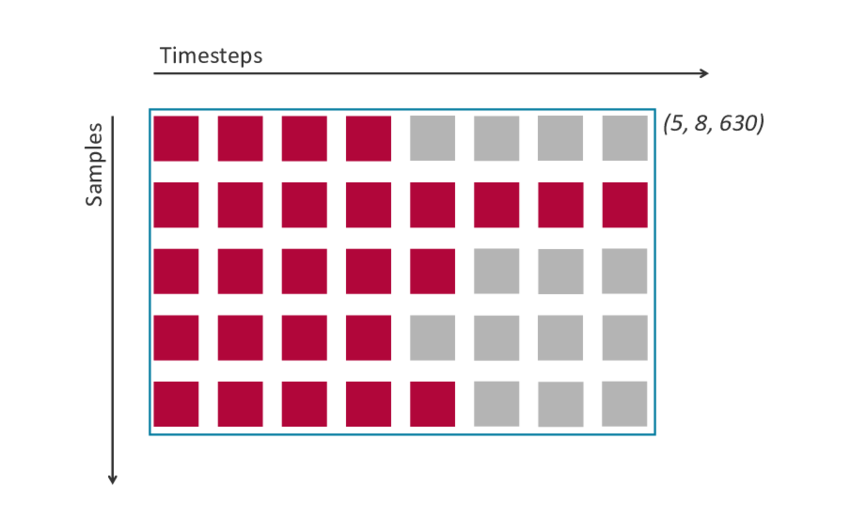

Here you can see a padded batch, The **GRAY** elements are added to have the same size for each sample.

**Data collators** are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

Link to huggingface documentation for the Data Collator functions (https://huggingface.co/docs/transformers/main_classes/data_collator)

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_11,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7955625105877312, metrics={'train_runtime': 36.3419, 'train_samples_per_second': 172.005, 'train_steps_per_second': 5.393, 'total_flos': 103442324639616.0, 'train_loss': 0.7955625105877312, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.702393651008606,
 'eval_accuracy': 0.7033333333333334,
 'eval_f1': 0.6933780026436938,
 'eval_precision': 0.6889427609427609,
 'eval_recall': 0.7033333333333334,
 'eval_cm': array([[ 37,  35,   4],
        [ 26,  62,  19],
        [  3,   2, 112]]),
 'eval_runtime': 2.8289,
 'eval_samples_per_second': 106.047,
 'eval_steps_per_second': 13.433,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_11, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_11, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_11, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_11, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_11, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Caponata", model_11, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("Bread", model_11, tokenizer, "cuda:0")

'cultural exclusive'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_11, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,0
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,0


Accuracy: 0.7033333333333334
Precision (weighted): 0.6889427609427609
Recall (weighted): 0.7033333333333334
F1-score (weighted): 0.6933780026436938

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.56      0.49      0.52        76
representative       0.63      0.58      0.60       107
      agnostic       0.83      0.96      0.89       117

      accuracy                           0.70       300
     macro avg       0.67      0.67      0.67       300
  weighted avg       0.69      0.70      0.69       300



<Figure size 600x600 with 0 Axes>

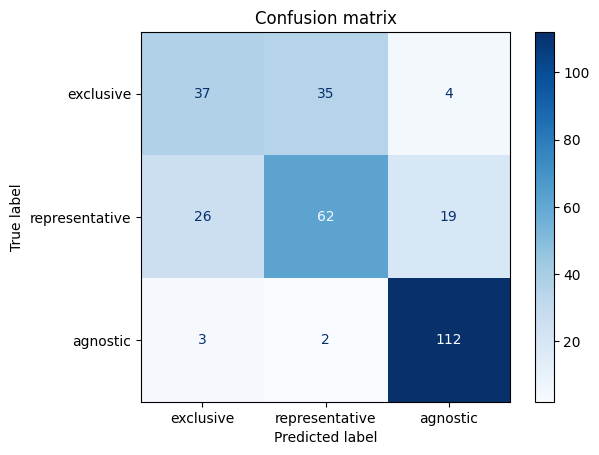

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

### Model 1.2

We modify the input :

Instead of having the description as input, we use the descrpition AND the name of the item

In [ ]:
## Initialize the model
model_12 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    text_inputs = [f"{name}: {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(text_inputs, padding=True, truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_12,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7506593976702008, metrics={'train_runtime': 38.0968, 'train_samples_per_second': 164.082, 'train_steps_per_second': 5.145, 'total_flos': 109944727049880.0, 'train_loss': 0.7506593976702008, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6154641509056091,
 'eval_accuracy': 0.7266666666666667,
 'eval_f1': 0.720058064516129,
 'eval_precision': 0.7178795589482612,
 'eval_recall': 0.7266666666666667,
 'eval_cm': array([[ 44,  29,   3],
        [ 29,  62,  16],
        [  3,   2, 112]]),
 'eval_runtime': 2.8337,
 'eval_samples_per_second': 105.868,
 'eval_steps_per_second': 13.41,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_12, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_12, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_12, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_12, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_12, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Caponata", model_12, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Bread", model_12, tokenizer, "cuda:0")

'cultural agnostic'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_12, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,0
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,0


Accuracy: 0.6733333333333333
Precision (weighted): 0.6572264997092583
Recall (weighted): 0.6733333333333333
F1-score (weighted): 0.6577459711777979

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.52      0.45      0.48        76
representative       0.64      0.52      0.58       107
      agnostic       0.76      0.96      0.85       117

      accuracy                           0.67       300
     macro avg       0.64      0.64      0.63       300
  weighted avg       0.66      0.67      0.66       300



<Figure size 600x600 with 0 Axes>

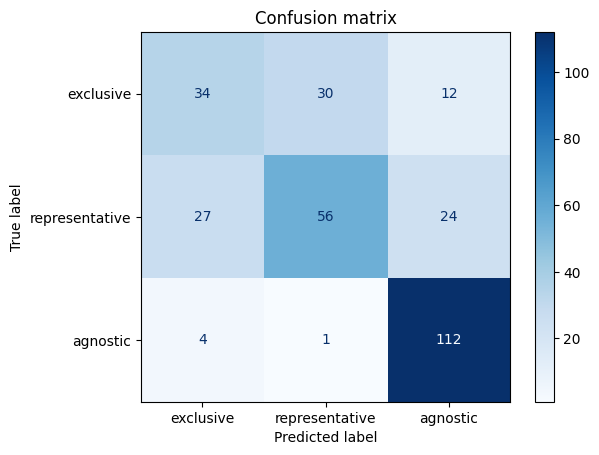

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

Observation : Adding the name as input decrease the accuracy

### Model 1.3

We still try to use the name of the item as input. But instead of using it as a variable, we merge it with the descrition. For exemple

- Name = Meutre à la tronconeuse
- Descrition = French Horror Moovie

The input becomes : Meutre à la tronconeuse - French Horror Moovie

In [ ]:
## Initialize the model
model_13 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_13,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7623533910634567, metrics={'train_runtime': 38.8734, 'train_samples_per_second': 160.804, 'train_steps_per_second': 5.042, 'total_flos': 109944727049880.0, 'train_loss': 0.7623533910634567, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6018779277801514,
 'eval_accuracy': 0.7433333333333333,
 'eval_f1': 0.735992220630775,
 'eval_precision': 0.7328016197142102,
 'eval_recall': 0.7433333333333333,
 'eval_cm': array([[ 42,  32,   2],
        [ 22,  68,  17],
        [  3,   1, 113]]),
 'eval_runtime': 2.8947,
 'eval_samples_per_second': 103.639,
 'eval_steps_per_second': 13.128,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_13, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_13, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_13, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_13, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_13, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Caponata", model_13, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Bread", model_13, tokenizer, "cuda:0")

'cultural agnostic'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_13, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,0
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,0


Accuracy: 0.71
Precision (weighted): 0.6986600473746546
Recall (weighted): 0.71
F1-score (weighted): 0.6938925950427058

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.65      0.43      0.52        76
representative       0.67      0.63      0.65       107
      agnostic       0.76      0.97      0.85       117

      accuracy                           0.71       300
     macro avg       0.69      0.68      0.67       300
  weighted avg       0.70      0.71      0.69       300



<Figure size 600x600 with 0 Axes>

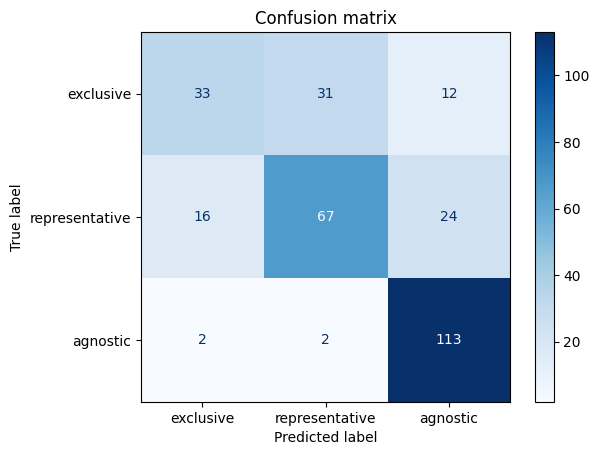

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

That's the best accuracy we've ever had for now !

### Model 1.4


let's try using extract of the wikipedia text

In [8]:
#adding text columns
train_df = pd.merge(train_df, df_train_text, on='item', how='left')
dev_df = pd.merge(dev_df, df_dev_text, on='item', how='left')

train_df["idx"] = range(len(train_df))
dev_df["idx"] = range(len(dev_df))

# Creation of the dictionnary datasets
train_dict = train_df[['idx','name','text','label']].to_dict(orient="list")
train_dataset = Dataset.from_dict(train_dict)

dev_dict = dev_df[['idx','name','text','label']].to_dict(orient="list")
dev_dataset = Dataset.from_dict(dev_dict)

# Merge the datasets into one single dictionnary
datasets = DatasetDict({
    "train": train_dataset,
    "dev": dev_dataset
})

# Visualisation
datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'name', 'text', 'label'],
        num_rows: 6251
    })
    dev: Dataset({
        features: ['idx', 'name', 'text', 'label'],
        num_rows: 300
    })
})

In [9]:
## Initialize the model
model_14 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [desc for desc in examples["text"]]
    return tokenizer(inputs, padding=True, truncation=True)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

In [11]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [12]:
trainer = Trainer(
   model=model_14,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [13]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7542581363600127, metrics={'train_runtime': 176.9665, 'train_samples_per_second': 35.323, 'train_steps_per_second': 1.108, 'total_flos': 591914736675540.0, 'train_loss': 0.7542581363600127, 'epoch': 1.0})

In [14]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.5993524789810181,
 'eval_accuracy': 0.7366666666666667,
 'eval_f1': 0.7271949403405119,
 'eval_precision': 0.7367288538932635,
 'eval_recall': 0.7366666666666667,
 'eval_cm': array([[ 34,  40,   2],
        [ 13,  78,  16],
        [  1,   7, 109]]),
 'eval_runtime': 4.5166,
 'eval_samples_per_second': 66.422,
 'eval_steps_per_second': 8.413,
 'epoch': 1.0}

#### Inference

In [15]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

#### Evaluation

In [16]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['text'].apply(lambda x: predict_culture(x, model_14, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,text,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,1. Fußball-Club Nürnberg Verein für Leibesübun...,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,77 Records was a British record company and la...,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,A Bug's Life (stylized in all lowercase) is a ...,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,A Gang Story (French: Les Lyonnais) is a 2011 ...,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,"Aaron Copland (, KOHP-lənd; November 14, 1900 ...",1
...,...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,A writer is a person who uses written words in...,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,The Würzburg Residence (German: Würzburger Res...,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,A xunfu was an important imperial Chinese prov...,0
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,Ivan Daminikavich Lutsevich (Belarusian: Іван ...,0


Accuracy: 0.74
Precision (weighted): 0.7357721566627816
Recall (weighted): 0.74
F1-score (weighted): 0.7328317040556681

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.69      0.50      0.58        76
representative       0.64      0.70      0.67       107
      agnostic       0.85      0.93      0.89       117

      accuracy                           0.74       300
     macro avg       0.73      0.71      0.71       300
  weighted avg       0.74      0.74      0.73       300



<Figure size 600x600 with 0 Axes>

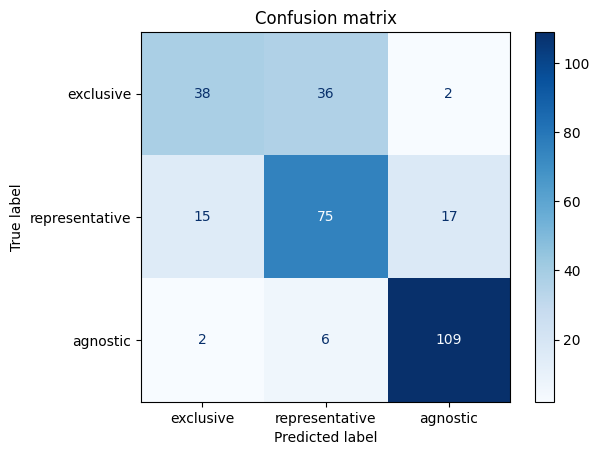

In [17]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

## Model 2 : DeBERTa

In [ ]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "microsoft/deberta-v3-small"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [ ]:
## Initialize the model
model_21 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_21,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.80297259895169, metrics={'train_runtime': 51.684, 'train_samples_per_second': 120.946, 'train_steps_per_second': 3.792, 'total_flos': 103495687200000.0, 'train_loss': 0.80297259895169, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.7146365642547607,
 'eval_accuracy': 0.7,
 'eval_f1': 0.6857594363764534,
 'eval_precision': 0.686941505165643,
 'eval_recall': 0.7,
 'eval_cm': array([[ 42,  30,   4],
        [ 21,  55,  31],
        [  2,   2, 113]]),
 'eval_runtime': 3.6149,
 'eval_samples_per_second': 82.99,
 'eval_steps_per_second': 10.512,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_21, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("President of Paraguay", model_21, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_21, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("Sleep", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Caponata", model_21, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Bread", model_21, tokenizer, "cuda:0")

'cultural agnostic'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_21, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,2
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,1
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,0


Accuracy: 0.6433333333333333
Precision (weighted): 0.635569424514933
Recall (weighted): 0.6433333333333333
F1-score (weighted): 0.6162637878828241

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.58      0.41      0.48        76
representative       0.64      0.44      0.52       107
      agnostic       0.66      0.98      0.79       117

      accuracy                           0.64       300
     macro avg       0.63      0.61      0.60       300
  weighted avg       0.64      0.64      0.62       300



<Figure size 600x600 with 0 Axes>

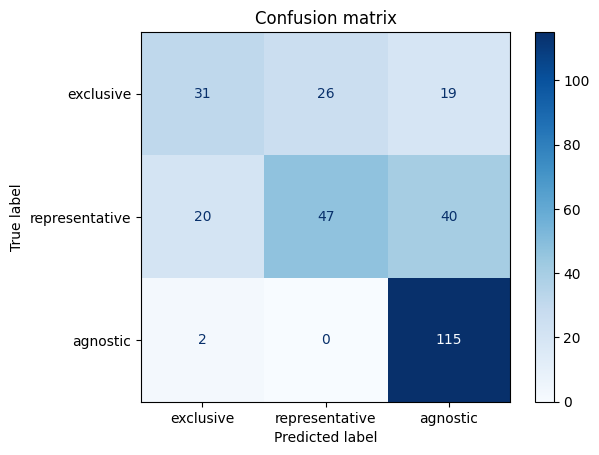

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

## Model 3 : RoBERTa

In [ ]:
### Model Parameters
# we will use with Distil-BERT
language_model_name = "roberta-base"

### Training Argurments

# this GPU should be enough for this task to handle 32 samples per batch
batch_size = 32

# optim
learning_rate = 1e-4
weight_decay = 0.001 # we could use e.g. 0.01 in case of very low and very high amount of data for regularization

# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"


set_seed(42)

In [ ]:
## Initialize the model
model_31 = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

# Load the pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# Set the data collator
# Function used to prepare the data before the training.
# the data collator function used here apply a zero-padding on the elements in the batch
# the padding is needed to have a "full" form of the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    inputs = [f"{name} - {desc}" for name, desc in zip(examples["name"], examples["description"])]
    return tokenizer(inputs, padding=True, truncation=True)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

#### Training

To train a transformer model you can rely on the **Trainer** class of Huggingface (https://huggingface.co/docs/transformers/main_classes/trainer).

The Trainer class allows you to save many lines of code, and makes your code much more readable.

To initialize the Trainer class you have to define a **TrainerArguments** object.

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",                    # output directory [Mandatory]
    num_train_epochs=epochs,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,                  # learning rate
    report_to="none",
    logging_dir="sentiment_analysis_logs"         # use it later to get the training curves
)

In [ ]:
trainer = Trainer(
   model=model_31,
   args=training_args,
   train_dataset=tokenized_datasets['train'],
   eval_dataset=tokenized_datasets["dev"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss


TrainOutput(global_step=196, training_loss=0.7689237010722257, metrics={'train_runtime': 79.0968, 'train_samples_per_second': 79.03, 'train_steps_per_second': 2.478, 'total_flos': 231124581738288.0, 'train_loss': 0.7689237010722257, 'epoch': 1.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

{'eval_loss': 0.6331952810287476,
 'eval_accuracy': 0.7166666666666667,
 'eval_f1': 0.7162604093813523,
 'eval_precision': 0.7168085587532048,
 'eval_recall': 0.7166666666666667,
 'eval_cm': array([[ 41,  32,   3],
        [ 26,  71,  10],
        [  3,  11, 103]]),
 'eval_runtime': 3.2394,
 'eval_samples_per_second': 92.61,
 'eval_steps_per_second': 11.731,
 'epoch': 1.0}

#### Inference

In [ ]:
def predict_culture(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return (
        "cultural exclusive" if preds.item() == 0
        else "cultural representative" if preds.item() == 1
        else "cultural agnostic"
    )

In [ ]:
predict_culture("President of America", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("President of Paraguay", model_31, tokenizer, "cuda:0")

'cultural exclusive'

In [ ]:
predict_culture("River", model_31, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Sleep", model_31, tokenizer, "cuda:0")

'cultural agnostic'

In [ ]:
predict_culture("Pizza", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Caponata", model_31, tokenizer, "cuda:0")

'cultural representative'

In [ ]:
predict_culture("Bread", model_31, tokenizer, "cuda:0")

'cultural representative'

#### Evaluation

In [ ]:
# Apply the model on the dev set
dev_df['predict_label_transformer'] = dev_df['description'].apply(lambda x: predict_culture(x, model_31, tokenizer, "cuda:0"))

# Transform the labels into integers
dict_mapping ={'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].map(dict_mapping)
dev_df['predict_label_transformer'] = dev_df['predict_label_transformer'].apply(lambda x: np.array(x))

# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,idx,predict_label_transformer
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,1,0,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,1,1
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,1,2,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,3,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,1,4,1
...,...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,2,295,2
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,1,296,0
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,0,297,1
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,1,298,1


Accuracy: 0.6866666666666666
Precision (weighted): 0.6701554937523816
Recall (weighted): 0.6866666666666666
F1-score (weighted): 0.666291362097034

 Classification Report:
                precision    recall  f1-score   support

     exclusive       0.58      0.33      0.42        76
representative       0.62      0.67      0.65       107
      agnostic       0.77      0.93      0.84       117

      accuracy                           0.69       300
     macro avg       0.66      0.64      0.64       300
  weighted avg       0.67      0.69      0.67       300



<Figure size 600x600 with 0 Axes>

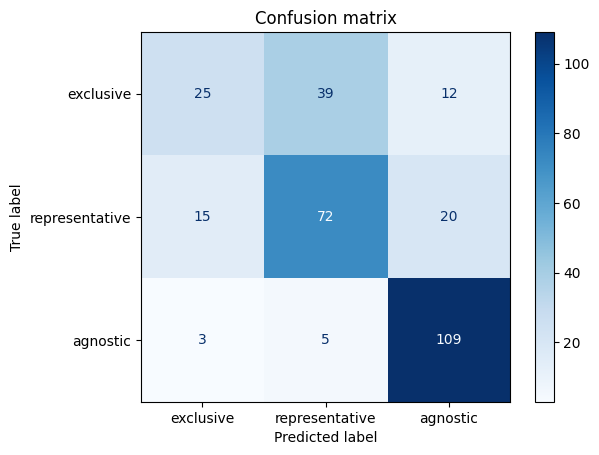

In [ ]:
# Extract the true and predicted labels
y_true = dev_df['label']
y_pred = dev_df['predict_label_transformer']

# Visualisation of the evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average="weighted"))
print("Recall (weighted):", recall_score(y_true, y_pred, average="weighted"))
print("F1-score (weighted):", f1_score(y_true, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=["exclusive", "representative", "agnostic"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["exclusive", "representative", "agnostic"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()